<a href="https://colab.research.google.com/github/sanjanaksuresh/network-data-prj/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
from google.colab import files
data=files.upload()

Saving network data.csv to network data (1).csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("network data.csv")

print("✔ Dataset Loaded Successfully!\n")
print(df.head())


✔ Dataset Loaded Successfully!

   Unnamed: 0  id.orig_p  id.resp_p proto service  flow_duration  \
0           0      38667       1883   tcp    mqtt      32.011598   
1           1      51143       1883   tcp    mqtt      31.883584   
2           2      44761       1883   tcp    mqtt      32.124053   
3           3      60893       1883   tcp    mqtt      31.961063   
4           4      51087       1883   tcp    mqtt      31.902362   

   fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  ...  \
0             9             5                  3                  3  ...   
1             9             5                  3                  3  ...   
2             9             5                  3                  3  ...   
3             9             5                  3                  3  ...   
4             9             5                  3                  3  ...   

   active.std     idle.min     idle.max     idle.tot     idle.avg  idle.std  \
0         0.0  29729182

In [ ]:
X = df.drop("fwd_pkts_tot", axis=1)      # <-- fraud column is label
y = df["fwd_pkts_tot"]

numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

In [ ]:
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
model.fit(X_train, y_train)
print("\n✔ Model Training Completed!")



✔ Model Training Completed!


In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [ ]:
y_prob_multiclass = model.predict_proba(X_test)

print("\n============= MODEL PERFORMANCE ============")
print("Accuracy  :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall    :", recall_score(y_test, y_pred, average='weighted', zero_division=0))

# Get the classes from the trained model. These are the classes the model can predict
model_classes = model.named_steps['classifier'].classes_

# Filter y_test and y_prob_multiclass to only include samples whose true labels
# are present in the model's known classes. This resolves the 'labels not in parameter labels' error.
known_class_indices = y_test.isin(model_classes)
y_test_filtered = y_test[known_class_indices]
y_prob_multiclass_filtered = y_prob_multiclass[known_class_indices]

# Calculate ROC-AUC using the filtered data and the model's known classes.
# This resolves the 'Number of given labels not equal to number of columns in y_score' error.
print("ROC-AUC   :", roc_auc_score(y_test_filtered, y_prob_multiclass_filtered, multi_class='ovr', average='weighted', labels=model_classes))
print("==============================================\n")


============= MODEL PERFORMANCE ============
Accuracy  : 0.9925276153346329
Precision : 0.9925461432261216
Recall    : 0.9925276153346329
ROC-AUC   : 0.9995443338166321



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

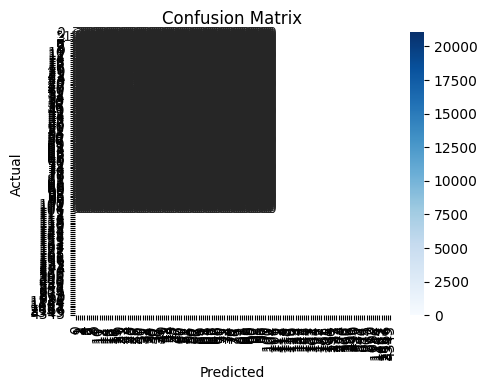

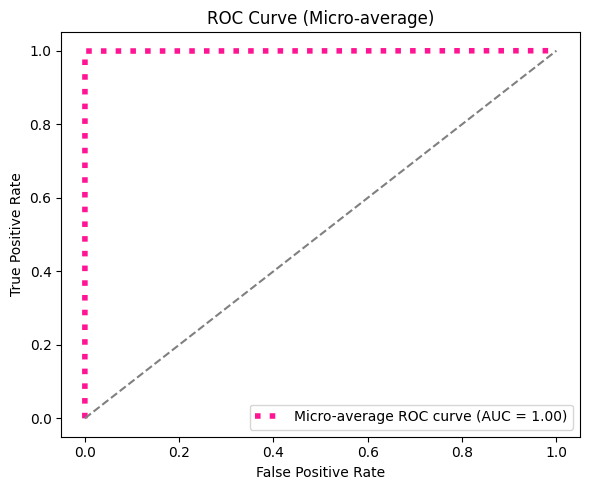

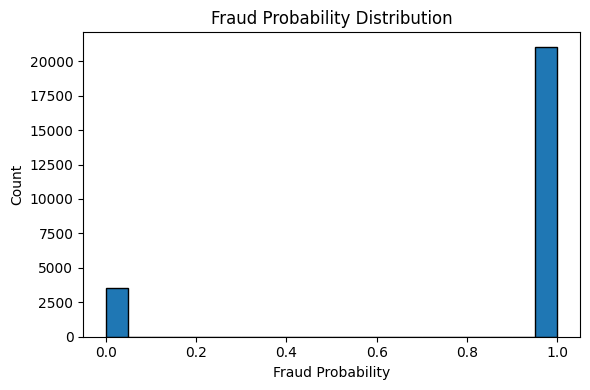

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model_classes, # Use actual model classes for better representation
            yticklabels=model_classes) # Use actual model classes for better representation
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
from sklearn.preprocessing import label_binarize


model_classes = model.named_steps['classifier'].classes_


y_test_binarized_filtered = label_binarize(y_test_filtered, classes=model_classes)
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized_filtered.ravel(), y_prob_multiclass_filtered.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(6,5))
plt.plot(fpr_micro, tpr_micro, label=f"Micro-average ROC curve (AUC = {roc_auc_micro:.2f})", color='deeppink', linestyle=':', linewidth=4)
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Micro-average)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,4))
plt.hist(y_prob, bins=20, edgecolor="black")
plt.title("Fraud Probability Distribution")
plt.xlabel("Fraud Probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
sample_data = X.iloc[0].copy()

# Modify some values to create a new sample.
# For example, let's change a few numerical values and a categorical one.
# The actual values don't matter as much as having the correct columns.

# Example of modifying some numerical features
sample_data['flow_duration'] = 15.0
sample_data['fwd_data_pkts_tot'] = 5

# Example of modifying a categorical feature (ensure it's a valid category the model saw or use handle_unknown='ignore')
# Assuming 'proto' is a categorical column and 'tcp' is one of its values
# If 'service' is categorical, you might change it too
sample_data['proto'] = 'tcp'

# Create the DataFrame for prediction
sample = pd.DataFrame([sample_data])

pred = model.predict(sample)[0]
# For multiclass, predict_proba returns probabilities for all classes. We want the highest probability.
prob_all_classes = model.predict_proba(sample)[0]
prob = prob_all_classes.max() # Get the max probability for the predicted class

print("\n=== SAMPLE PREDICTION ===")
print("Predicted fwd_pkts_tot :", pred)
print("Probability of predicted class:", prob)



=== SAMPLE PREDICTION ===
Predicted fwd_pkts_tot : 9
Probability of predicted class: 0.98
